In [1]:
# Mass ratio of all mergers (Historam, against redshift?)

import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/u/e/jb2854/Mergers_Project')
from illustris_python import illustris_python as il

basePath = '/x/Physics/AstroPhysics/Shared-New/DATA/IllustrisTNG/TNG100-1/output'

In [2]:
# Function modified from NumMergers in Sublink to pull any given properties of all mergers in a given tree

def mergerInfo(tree, minMassRatio=1e-10, massPartType='stars', index=0):
    """ Based off numMergers function to identify the mergers, this function returns the two progenitor masses (default stellar) and the snapshot in which merging occured"""
    # verify the input sub-tree has the required fields
    reqFields = ['SubhaloID', 'NextProgenitorID', 'MainLeafProgenitorID',
                 'FirstProgenitorID', 'SubhaloMassType','SnapNum', 'DescendantID']

    if not set(reqFields).issubset(tree.keys()):
        raise Exception('Error: Input tree needs to have loaded fields: '+', '.join(reqFields))

    numMergers   = 0
    mergerProgenitors = []
    invMassRatio = 1.0 / minMassRatio

    # walk back main progenitor branch
    rootID = tree['SubhaloID'][index]
    fpID   = tree['FirstProgenitorID'][index]

    while fpID != -1:
        fpIndex = index + (fpID - rootID)
        fpMass  = il.sublink.maxPastMass(tree, fpIndex, massPartType)

        # explore breadth
        npID = tree['NextProgenitorID'][fpIndex]

        while npID != -1:
            npIndex = index + (npID - rootID)
            npMass  = il.sublink.maxPastMass(tree, npIndex, massPartType)

            # count if both masses are non-zero, and ratio exceeds threshold
            if fpMass > 1e-6 and npMass > 1e-6:
                ratio = npMass / fpMass

                if ratio >= minMassRatio and ratio <= invMassRatio:
                    numMergers += 1
                    mergerProgenitors.append([fpMass, npMass, ratio, tree['SnapNum'][fpIndex], tree['DescendantID'][fpIndex], tree['SubhaloMassType'][fpIndex-1, il.util.partTypeNum('dm')], tree['SubhaloMassType'][fpIndex-1, il.util.partTypeNum('stars')]])

            npID = tree['NextProgenitorID'][npIndex]

        fpID = tree['FirstProgenitorID'][fpIndex]

    return mergerProgenitors

In [3]:
# Set minimum mass ratio we are interested in
ratio = 1.0/20.0

# the following fields are required for the walk and the mass ratio analysis
fields = ['SubhaloID','NextProgenitorID','MainLeafProgenitorID','FirstProgenitorID','SubhaloMassType','SnapNum', 'DescendantID']

ratios = []
start = 0

# Get index of the primary galaxy in each group
groupFirstSub = il.groupcat.loadHalos(basePath,99,fields=['GroupFirstSub'])

# Function to find the mass ratios of all mergers in the tree of a given set of SubHaloIds at z=0
def findRatios(start, end, step, massType='stars'):
    ratios = np.zeros([0,4])
    groupFirstSub = il.groupcat.loadHalos(basePath,99,fields=['GroupFirstSub']) # Load subhalos at z=0
    for i in range(start, start + (end-start), step):
        tree = il.sublink.loadTree(basePath,99,groupFirstSub[i],fields=fields) # Load tree for specific sub halo
        mergerInfo2 = mergerInfo(tree,minMassRatio=ratio, massPartType = massType) # Extract merger info from tree
        for i in range(len(mergerInfo2)):
            if (mergerInfo2[i][2] > 1):
                mergerInfo2[i][2] = 1/mergerInfo2[i][2] # Inverse ratio if > 1
            ratios = np.vstack((ratios, np.array([mergerInfo2[i][2],mergerInfo2[i][3], mergerInfo2[i][5], mergerInfo2[i][6]])))
    return ratios
    

In [ ]:
#ratios_massive_stars = findRatios(0,10000,1, 'stars')
ratios_massive_dm = findRatios(0,30000,1, 'dm')
#ratios_massive_gas = findRatios(0,10000,1, 'gas')
#ratios_small = findRatios(5000000,5002000,1)

0.018706249073147774 6596.26416015625


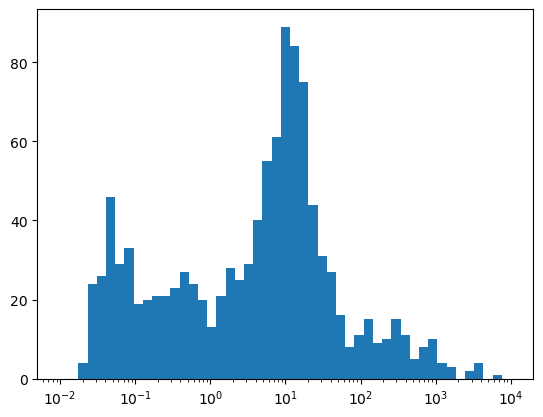

55188 97942 116093


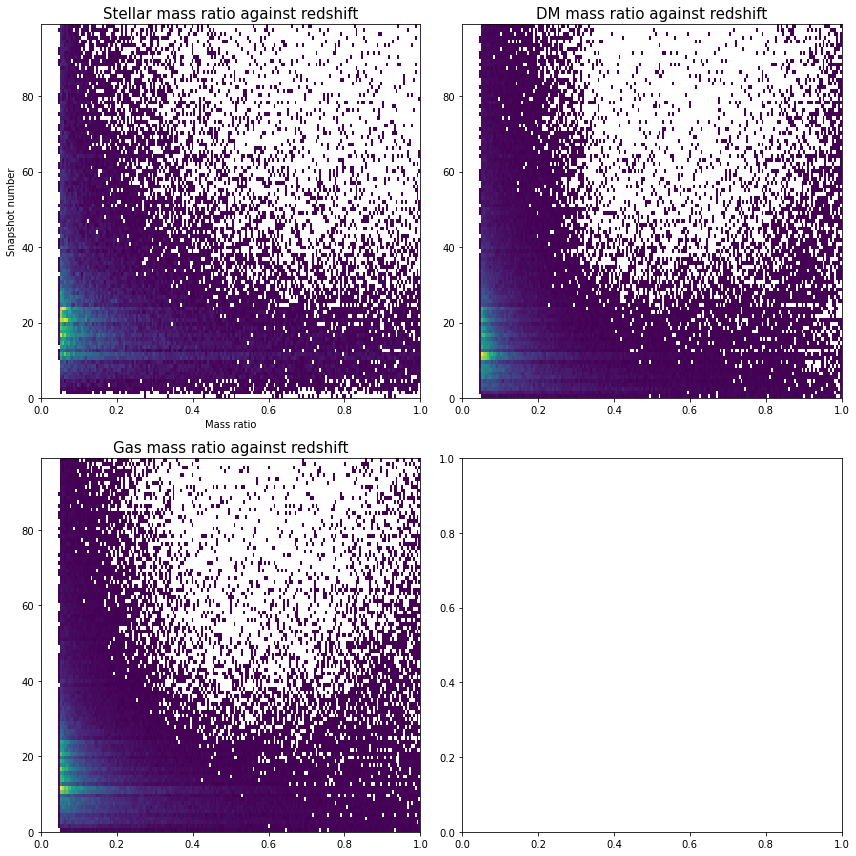

In [6]:
fig = plt.figure(figsize=(12,12))
axs = fig.subplots(nrows=2, ncols=2)
axs[0,0].hist2d(ratios_massive_stars[:,0], ratios_massive_stars[:,1], [np.linspace(0, 1, num=200), np.linspace(0, 99, num=99)], cmin=1)
axs[0,1].hist2d(ratios_massive_dm[:,0], ratios_massive_dm[:,1], [np.linspace(0, 1, num=200), np.linspace(0, 99, num=99)], cmin=1)
axs[1,0].hist2d(ratios_massive_gas[:,0], ratios_massive_gas[:,1], [np.linspace(0, 1, num=200), np.linspace(0, 99, num=99)], cmin=1)
axs[0,0].set_title('Stellar mass ratio against redshift', size=15)
axs[0,1].set_title('DM mass ratio against redshift', size=15)
axs[1,0].set_title('Gas mass ratio against redshift', size=15)
axs[0,0].set_xlabel('Mass ratio', size=10)
axs[0,0].set_ylabel('Snapshot number', size=10)
fig.tight_layout()

print(len(ratios_massive_stars), len(ratios_massive_dm), len(ratios_massive_gas))

In [7]:
def mergerstats(ratios_massive):
    mergerstats = np.zeros([99,2])
    for i in range(100):
        for j in range (len(ratios_massive[:,0])):
            if (ratios_massive[j,1] == i):
                mergerstats[i,0] += 1
                mergerstats[i,1] += ratios_massive[j,0]
    return mergerstats

/opt/anaconda3/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Number of mergers')

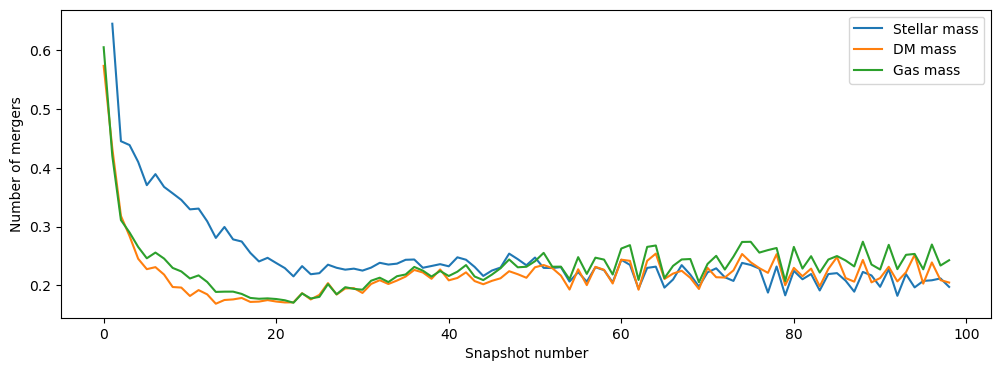

In [44]:
fig = plt.figure(figsize=(12,4))
axs = fig.subplots(nrows=1, ncols=1)
axs.plot(np.linspace(0,98,99), mergerstats(ratios_massive_stars)[:,1]/ mergerstats(ratios_massive_stars)[:, 0], label = 'Stellar mass')
axs.plot(np.linspace(0,98,99), mergerstats(ratios_massive_dm)[:, 1]/ mergerstats(ratios_massive_dm)[:, 0], label = 'DM mass')
axs.plot(np.linspace(0,98,99), mergerstats(ratios_massive_gas)[:, 1]/ mergerstats(ratios_massive_gas)[:, 0], label = 'Gas mass')
#axs[3].plot(np.linspace(0,98,99), mergerstats[:, 1]/ mergerstats[:, 0])
axs.legend(loc="upper right")



axs.set_xlabel('Snapshot number')
axs.set_ylabel('Average mass ratio')
axs.set_xlabel('Snapshot number')
axs.set_ylabel('Number of mergers')

In [23]:
mergerstats(ratios_massive_stars)[:,0]

array([  0.,  23.,  93., 188., 233., 182., 346., 313., 330., 300., 238.,
       526., 480., 190., 263., 230., 170., 236., 196., 161., 121., 179.,
       130., 120., 174.,  88., 124., 114.,  90.,  88.,  83., 101.,  73.,
        75.,  81.,  74.,  77.,  66.,  86.,  47.,  93.,  77.,  76.,  57.,
        57.,  81.,  52.,  50.,  51.,  75.,  70.,  41.,  59.,  59.,  57.,
        46.,  61.,  53.,  56.,  60.,  61.,  55.,  51.,  56.,  73.,  54.,
        51.,  48.,  44.,  50.,  46.,  39.,  50.,  47.,  37.,  41.,  55.,
        33.,  56.,  26.,  38.,  38.,  28.,  37.,  48.,  28.,  43.,  31.,
        47.,  37.,  28.,  42.,  30.,  41.,  34.,  31.,  37.,  31.,  27.])

In [40]:
print(np.min(ratios_massive_stars[:,1]))
print(np.min(ratios_massive_dm[:,1]))
print(np.min(ratios_massive_gas[:,1]))

1.0
0.0
0.0


In [ ]:
top_ratios = np.zeros([0,4])
for i in range (len(ratios_massive_dm)):
    if ratios_massive_dm[i,0] > 0.95:
        top_ratios = np.vstack((top_ratios, ratios_massive_dm[i,:]))

Text(0.5, 1.0, 'All snapshots, mass ratio > 0.95')

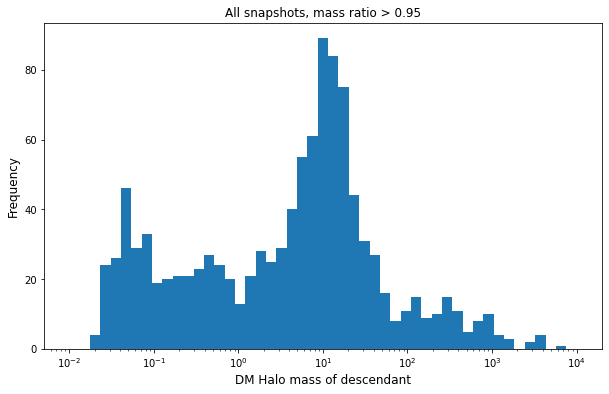

In [31]:
plt.figure(figsize = (10,6))
plt.hist(top_ratios[:,2], bins = np.logspace(-2, 4, 50))
plt.xscale('log')
plt.xlabel('DM Halo mass of descendant', size = 12)
plt.ylabel('Frequency', size = 12)
plt.title('All snapshots, mass ratio > 0.95')

In [ ]:
top_ratios_40 = np.zeros([0,4])
for i in range (len(top_ratios)):
    if top_ratios[i,1] > 40:
        top_ratios_40 = np.vstack((top_ratios_40, top_ratios[i,:]))

In [ ]:
plt.figure(figsize = (10,6))
plt.hist(top_ratios_40[:,2], bins = np.logspace(-2, 4, 50))
plt.xscale('log')
plt.xlabel('DM Halo mass of descendant', size = 12)
plt.ylabel('Frequency', size = 12)
plt.title('Snapshots 40 to 99, mass ratio > 0.95')

# Mass schechter function?

In [21]:
print(np.min(top_ratios_40[:,3]))
print(np.max(top_ratios_40[:,3]))

0.0005506763118319213
87.86619567871094


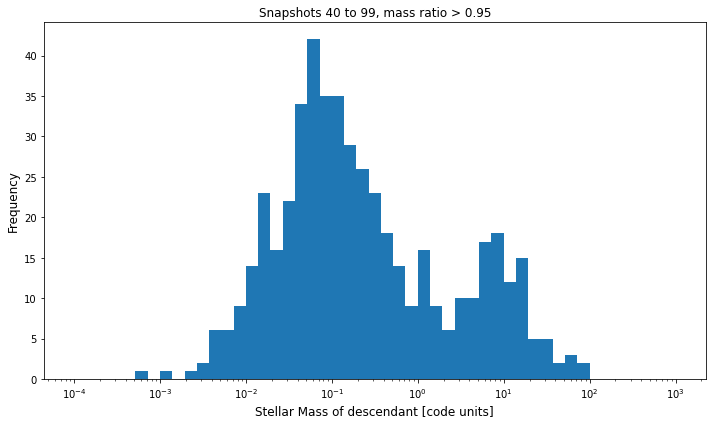

In [69]:
plt.figure(figsize = (10,6))
plt.hist(top_ratios_40[:,3], bins = np.logspace(-4, 3, 50))
plt.xscale('log')
plt.xlabel('Stellar Mass of descendant [code units]', size = 12)
plt.ylabel('Frequency', size = 12)
plt.title('Snapshots 40 to 99, mass ratio > 0.95')
plt.tight_layout()

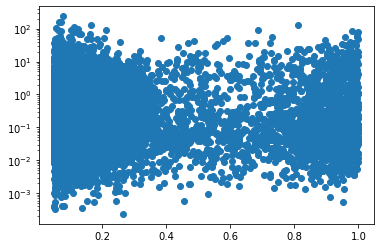

In [41]:
plt.scatter(greater_40[:,0], greater_40[:,3])
plt.yscale('log')

In [14]:
def plotSnapRange(start,ratio_data, end = 99):
    ratios = np.zeros([0,4])
    for i in range (len(ratio_data)):
        if (ratio_data[i,1] > start and ratio_data[i,1] < end):
            ratios = np.vstack((ratios, ratio_data[i,:]))
    return [ratios[:,0], ratios[:,3]]

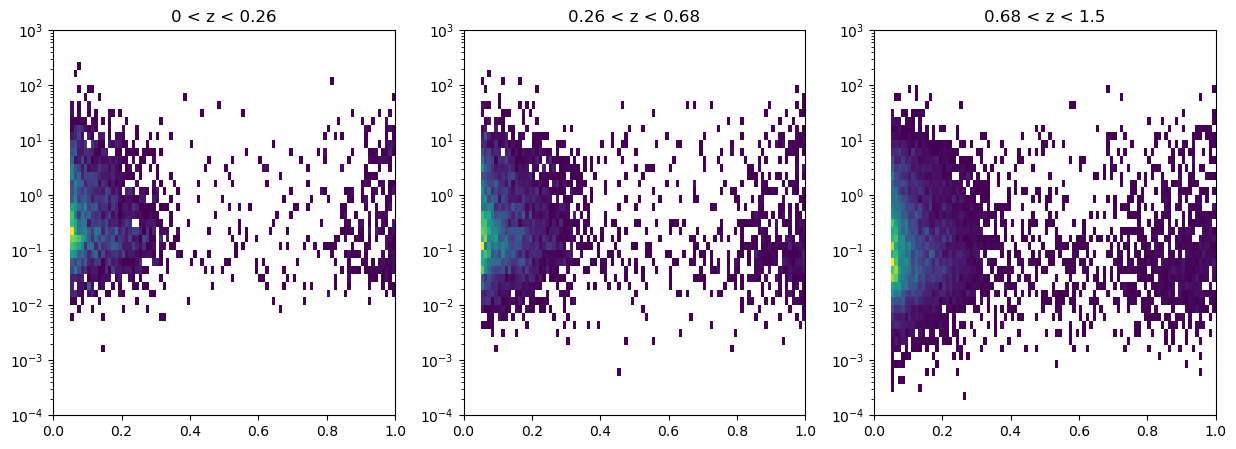

In [24]:
fig = plt.figure(figsize = (15,5))
ax = fig.subplots(nrows = 1, ncols = 3)

ax[0].hist2d(plotSnapRange(80,ratios_massive_dm,end = 99)[0], plotSnapRange(80,ratios_massive_dm,end = 99)[1], [np.linspace(0,1,101), np.logspace(-4, 3, 50)], cmin = 1)
ax[1].hist2d(plotSnapRange(60,ratios_massive_dm,end = 80)[0], plotSnapRange(60,ratios_massive_dm,end = 80)[1], [np.linspace(0,1,101), np.logspace(-4, 3, 50)], cmin = 1)
ax[2].hist2d(plotSnapRange(40,ratios_massive_dm,end = 60)[0], plotSnapRange(40,ratios_massive_dm,end = 60)[1], [np.linspace(0,1,101), np.logspace(-4, 3, 50)], cmin = 1)
ax[0].set_yscale('log')
ax[0].set_title('0 < z < 0.26')
ax[1].set_title('0.26 < z < 0.68')
ax[2].set_title('0.68 < z < 1.5')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

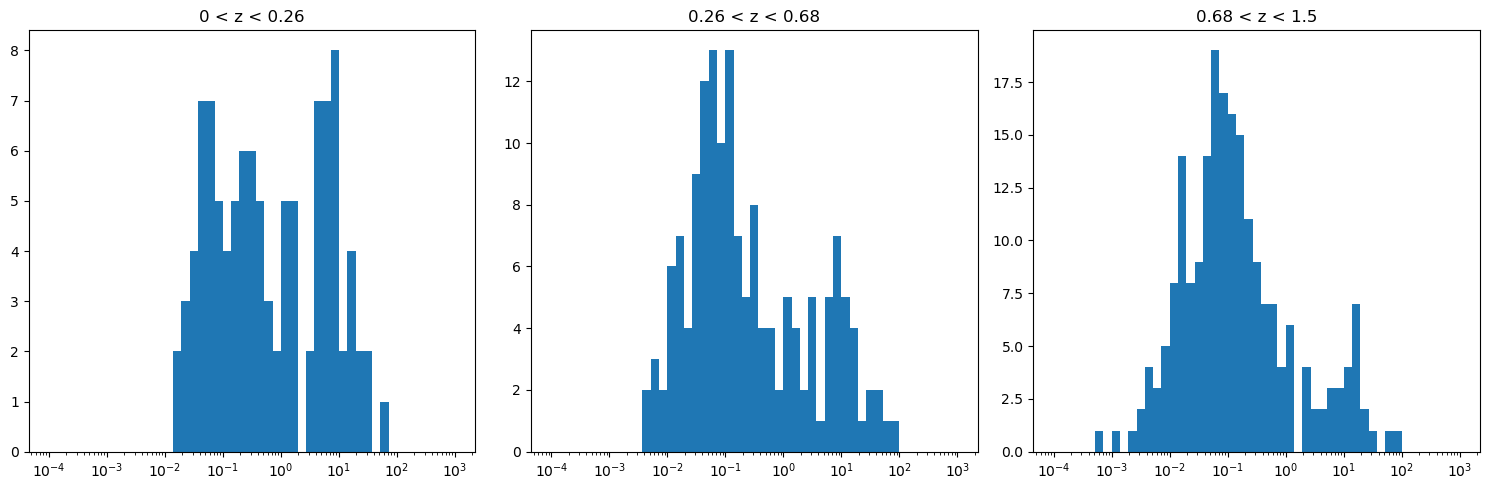

In [22]:
fig = plt.figure(figsize = (15,5))
ax = fig.subplots(nrows = 1, ncols = 3)

ax[0].hist(plotSnapRange(80, top_ratios, end = 99)[1], bins = np.logspace(-4, 3, 50))
ax[1].hist(plotSnapRange(60, top_ratios, end = 80)[1], bins = np.logspace(-4, 3, 50))
ax[2].hist(plotSnapRange(40, top_ratios, end = 60)[1], bins = np.logspace(-4, 3, 50))
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].set_title('0 < z < 0.26')
ax[1].set_title('0.26 < z < 0.68')
ax[2].set_title('0.68 < z < 1.5')
plt.tight_layout()